# EDA of datasets

## Analysis' colors of the raw dataset

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

DATASET_PATH = "../data/raw/dataset"


def scan_dataset(root_path):
    data = []
    root = Path(root_path)

    for img_path in root.rglob("*"):
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
            continue

        label = img_path.parent.name

        data.append({
            "filepath": str(img_path),
            "label": label
        })

    return pd.DataFrame(data)


def analyze_colors(df):
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = cv2.imread(row["filepath"], cv2.IMREAD_UNCHANGED)
        if img is None:
            continue

        if len(img.shape) == 2:
            mode = "GRAY"
            effective_gray = True
            channels = 1
        else:
            channels = img.shape[2]
            if channels == 3:
                mode = "RGB"
                effective_gray = np.allclose(img[:, :, 0], img[:, :, 1]) and np.allclose(img[:, :, 1], img[:, :, 2])
            else:
                mode = f"OTHER_{channels}"
                effective_gray = False

        results.append({
            "filepath": row["filepath"],
            "label": row["label"],
            "mode": mode,
            "channels": channels,
            "effective_gray": effective_gray
        })

    return pd.DataFrame(results)


df_meta = scan_dataset(DATASET_PATH)
df_color = analyze_colors(df_meta)

print("Total images analyzed:", len(df_color))
print(df_color.head())

os.makedirs("figures", exist_ok=True)
df_color.to_csv("figures/raw_color_analysis_dataset.csv", index=False)

summary = df_color.groupby("label").agg(
    total=("filepath", "count"),
    rgb=("mode", lambda x: (x == "RGB").sum()),
    gray=("mode", lambda x: (x == "GRAY").sum()),
    rgb_eff_gray=("effective_gray", lambda x: ((df_color.loc[x.index, "mode"] == "RGB") & x).sum())
).reset_index()

summary["rgb_pct"] = summary["rgb"] / summary["total"] * 100
summary["gray_pct"] = summary["gray"] / summary["total"] * 100
summary["rgb_eff_gray_pct"] = summary["rgb_eff_gray"] / summary["rgb"] * 100

print(summary)


100%|██████████| 26387/26387 [08:58<00:00, 48.97it/s]


Total images analyzed: 26387
                              filepath   label     mode  channels  \
0     ..\data\raw\dataset\glioma\0.png  glioma  OTHER_4         4   
1  ..\data\raw\dataset\glioma\0000.jpg  glioma      RGB         3   
2  ..\data\raw\dataset\glioma\0001.jpg  glioma      RGB         3   
3  ..\data\raw\dataset\glioma\0002.jpg  glioma      RGB         3   
4  ..\data\raw\dataset\glioma\0003.jpg  glioma      RGB         3   

   effective_gray  
0           False  
1            True  
2            True  
3            True  
4            True  
        label  total   rgb  gray  rgb_eff_gray    rgb_pct   gray_pct  \
0      glioma   9666  6814  1426          6814  70.494517  14.752742   
1  meningioma   8874  7458   708          7458  84.043272   7.978364   
2     notumor   3437  3405    29          3149  99.068955   0.843759   
3   pituitary   4410  2550   930          2550  57.823129  21.088435   

   rgb_eff_gray_pct  
0        100.000000  
1        100.000000  
2        

Graphics generation


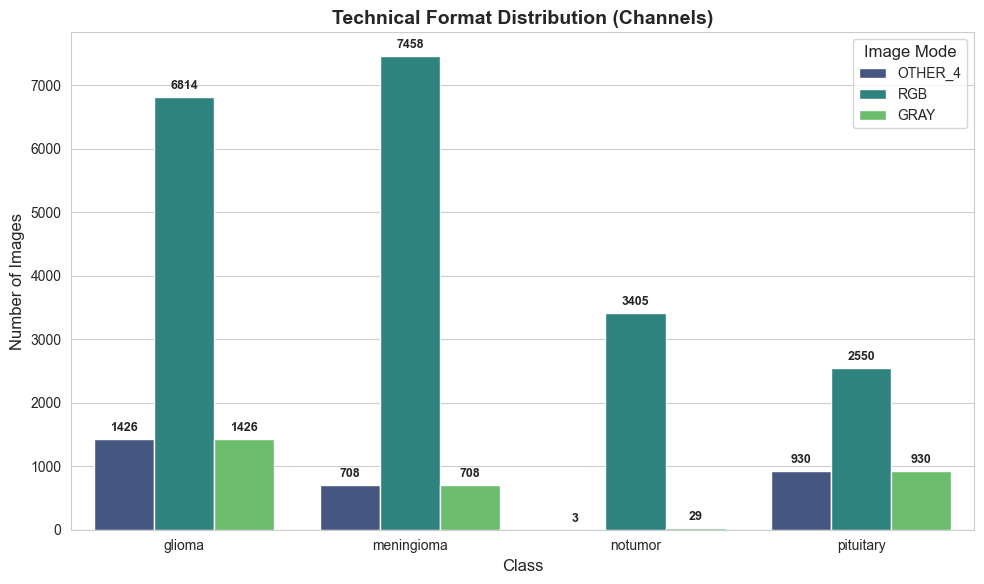

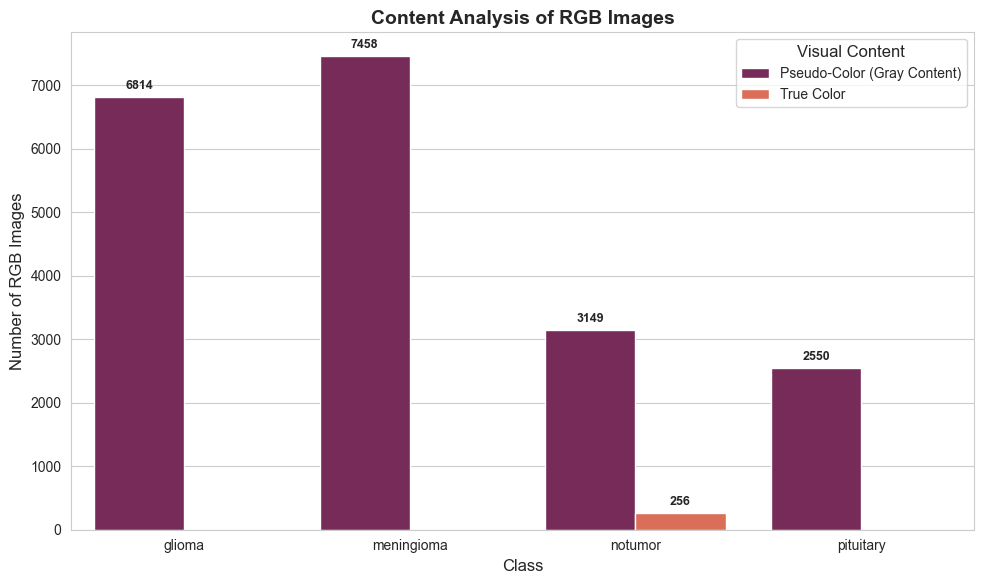

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

# Graph 1: Distribution of technical formats (RGB vs. GRAY)
def plot_technical_format(df):
    plt.figure(figsize=(10, 6))
    
    order = sorted(df['label'].unique())
    
    n_modes = df['mode'].nunique()
    palette = sns.color_palette("viridis", n_modes)
    ax = sns.countplot(x="label", hue="mode", data=df, order=order, palette=palette)
    
    plt.title("Technical Format Distribution (Channels)", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.legend(title="Image Mode")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0: 
            y_pos = height + (ax.get_ylim()[1] * 0.01)
            ax.text(p.get_x() + p.get_width() / 2., y_pos, 
                    f'{int(height)}', ha="center", va="bottom", fontsize=9, fontweight='bold')
            
    plt.tight_layout()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/raw_eda_technical_format.png", dpi=300)
    plt.show()


# Graph 2 : Analysis of "Effective Gray" 
def plot_effective_gray(df):

    df_rgb = df[df['mode'] == 'RGB'].copy()
    df_rgb['Content Type'] = df_rgb['effective_gray'].map({
        True: 'Pseudo-Color (Gray Content)', 
        False: 'True Color'
    })
    
    plt.figure(figsize=(10, 6))
    
    order = sorted(df_rgb['label'].unique())
    palette = sns.color_palette("rocket", 2) 
    ax = sns.countplot(x="label", hue="Content Type", data=df_rgb, order=order, palette=palette)
    plt.title("Content Analysis of RGB Images", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of RGB Images")
    plt.legend(title="Visual Content")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            y_pos = height + (ax.get_ylim()[1] * 0.01)
            ax.text(p.get_x() + p.get_width() / 2., y_pos, 
                    f'{int(height)}', ha="center", va="bottom", fontsize=9, fontweight='bold')
            
    plt.tight_layout()
    plt.savefig("figures/raw_eda_content_analysis.png", dpi=300)
    plt.show()

print("Graphics generation")
plot_technical_format(df_color)

if "RGB" in df_color["mode"].values:
    plot_effective_gray(df_color)
else:
    print("No RGB images detected")

## Final dataset analysis

Scanning dataset structure...
Total images found: 26258


,filepath,split,label
0,../data/processed/dataset_gestion_couleur\trai...,train,glioma
1,../data/processed/dataset_gestion_couleur\trai...,train,glioma
2,../data/processed/dataset_gestion_couleur\trai...,train,glioma
3,../data/processed/dataset_gestion_couleur\trai...,train,glioma
4,../data/processed/dataset_gestion_couleur\trai...,train,glioma


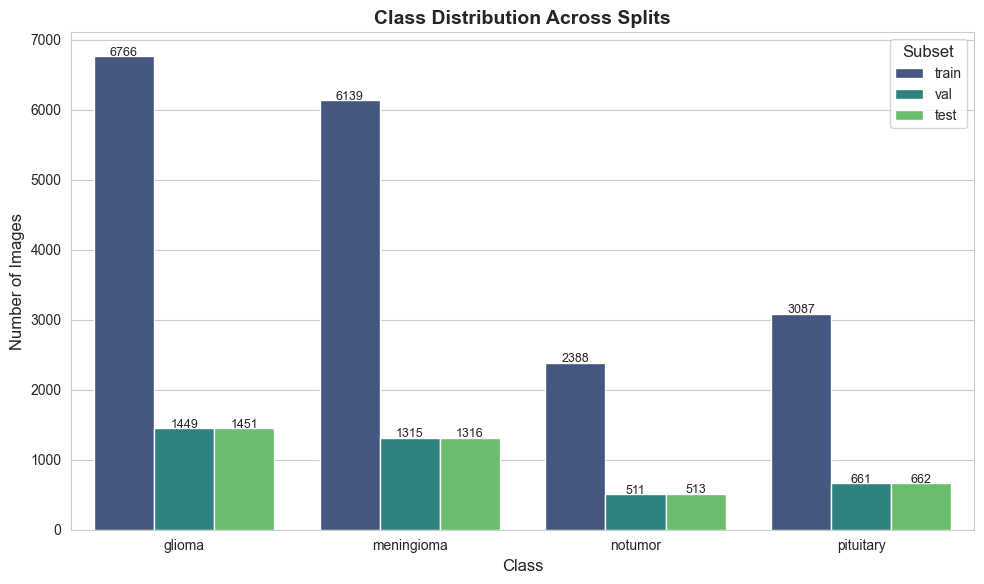

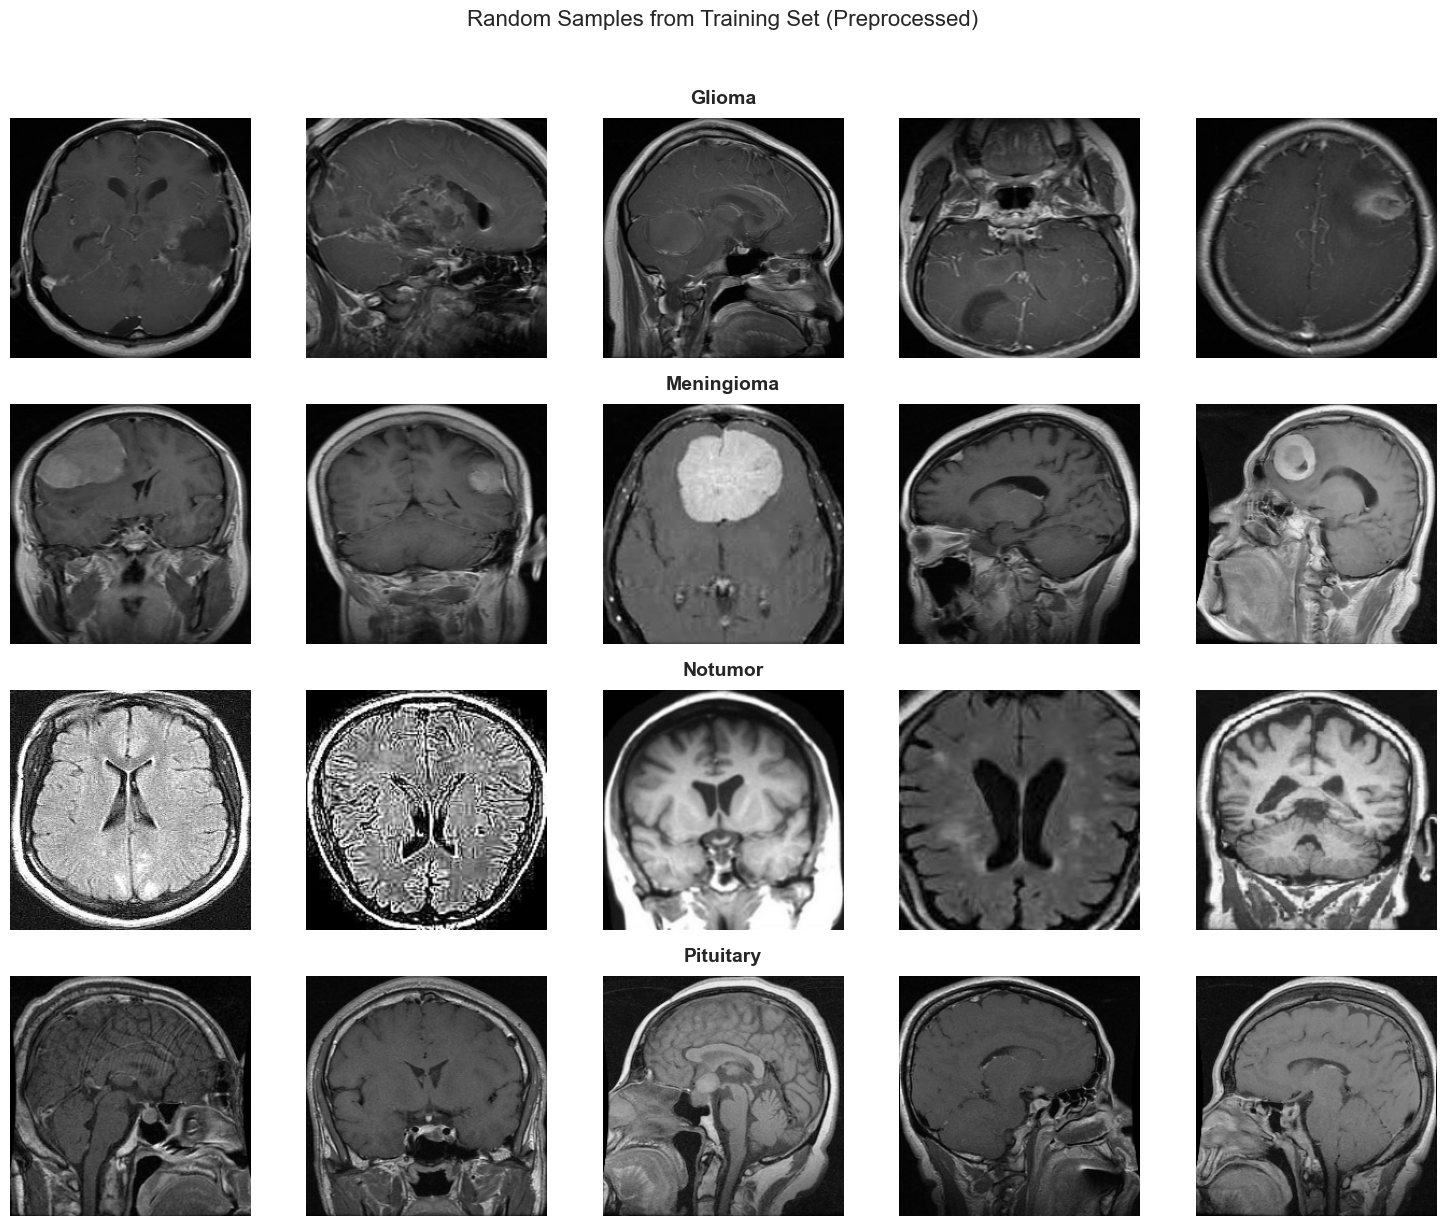

Calculating pixel intensities...


100%|██████████| 2000/2000 [00:05<00:00, 386.83it/s]
C:\Users\emma\AppData\Local\Temp\ipykernel_22532\551939570.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="mean_intensity", data=sample_df, palette="Set2")


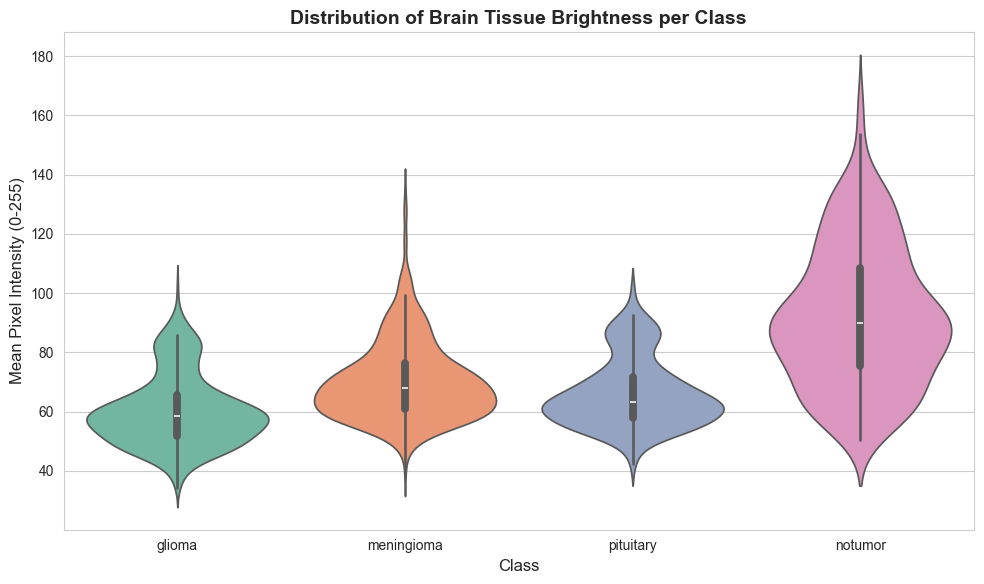

Computing average brains...


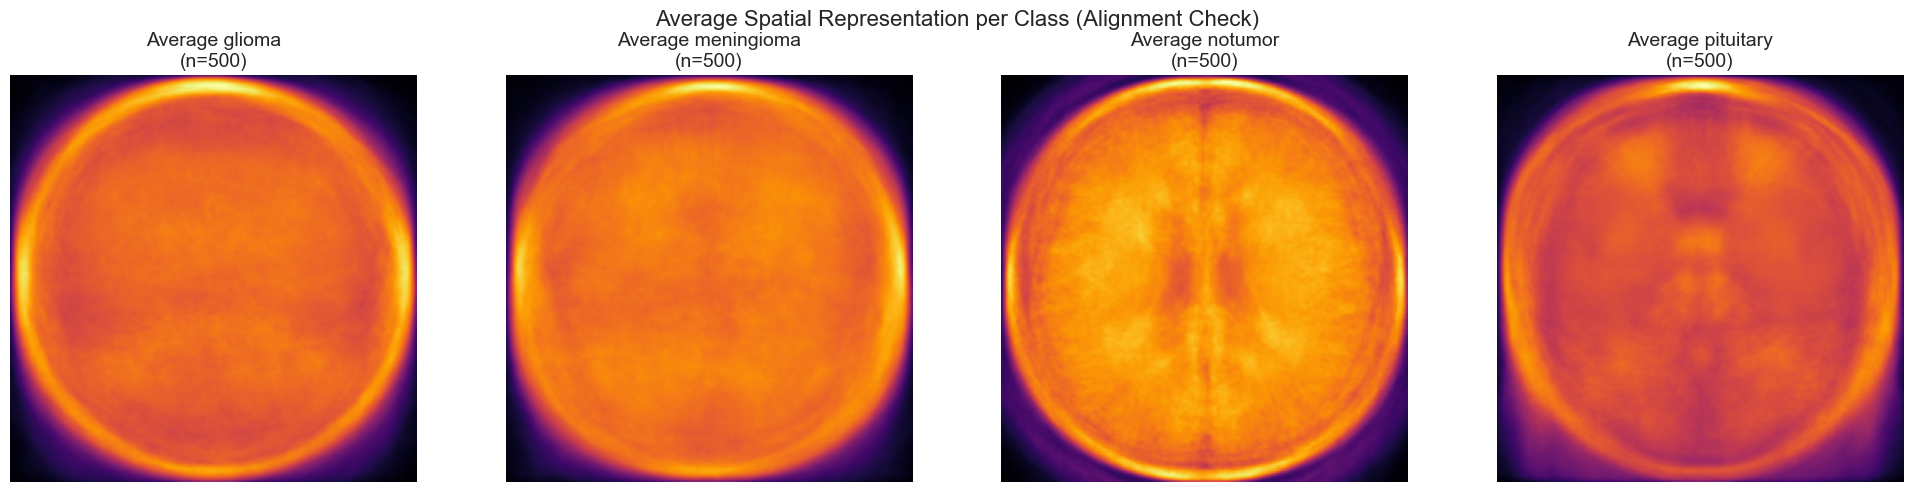

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

DATASET_PATH = "../data/processed/dataset_gestion_couleur" 

def build_metadata_dataframe(root_path):
    data = []
    splits = ['train', 'val', 'test']
    
    print("Scanning dataset structure...")
    for split in splits:
        split_path = os.path.join(root_path, split)
        if not os.path.exists(split_path):
            continue
            
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        
        for label in classes:
            class_path = os.path.join(split_path, label)
            files = glob.glob(os.path.join(class_path, "*"))
            
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append({
                        'filepath': f,
                        'split': split,
                        'label': label
                    })
    
    return pd.DataFrame(data)

# Loading
df = build_metadata_dataframe(DATASET_PATH)
print(f"Total images found: {len(df)}")
display(df.head())

# Figure 1
def plot_distribution(df):
    plt.figure(figsize=(10, 6))
    
    order = sorted(df['label'].unique())
    palette = sns.color_palette("viridis", 3) 
    ax = sns.countplot(x="label", hue="split", data=df, order=order, palette=palette)
    
    plt.title("Class Distribution Across Splits", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.legend(title="Subset")
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height + 5, 
                    f'{int(height)}', ha="center", fontsize=9)
            
    plt.tight_layout()
    plt.savefig("figures/final_eda_class_distribution.png", dpi=300)
    plt.show()

plot_distribution(df)

# Figure 2
def plot_samples(df, n_samples=5):
    classes = sorted(df['label'].unique())
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 3*len(classes)))
    
    for i, cls in enumerate(classes):
        subset = df[(df['label'] == cls) & (df['split'] == 'train')]
        samples = subset.sample(n_samples, random_state=42)['filepath'].values
        
        for j, img_path in enumerate(samples):
            img = cv2.imread(img_path)
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            axes[i, j].imshow(img, cmap='gray')
            if j == 2: 
                axes[i, j].set_title(cls.capitalize(), fontsize=14, fontweight='bold', pad=10)
            axes[i, j].axis('off')
            
    plt.suptitle("Random Samples from Training Set (Preprocessed)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig("figures/final_eda_visual_samples.png", dpi=300)
    plt.show()

plot_samples(df)


# Figure 3
def analyze_brightness(df):
    sample_df = df.sample(min(2000, len(df)), random_state=42).copy()
    
    intensities = []
    print("Calculating pixel intensities...")
    for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            mask = img > 0
            if np.sum(mask) > 0:
                mean_val = img[mask].mean()
            else:
                mean_val = 0
            intensities.append(mean_val)
        else:
            intensities.append(None)
            
    sample_df['mean_intensity'] = intensities
    sample_df = sample_df.dropna()
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="label", y="mean_intensity", data=sample_df, palette="Set2")
    plt.title("Distribution of Brain Tissue Brightness per Class", fontweight='bold')
    plt.xlabel("Class")
    plt.ylabel("Mean Pixel Intensity (0-255)")
    
    plt.tight_layout()
    plt.savefig("figures/final_eda_brightness_bias.png", dpi=300)
    plt.show()

analyze_brightness(df)


# Figure 4
def plot_average_brains(df):
    classes = sorted(df['label'].unique())
    
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    
    print("Computing average brains...")
    
    for i, cls in enumerate(classes):
        subset = df[(df['label'] == cls) & (df['split'] == 'train')]
        paths = subset.sample(min(500, len(subset)), random_state=42)['filepath'].values
        
        img_sum = None
        count = 0
        
        for path in paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (224, 224)) 
                img = img.astype(float)
                
                if img_sum is None:
                    img_sum = img
                else:
                    img_sum += img
                count += 1
        
        if count > 0:
            avg_img = img_sum / count
            axes[i].imshow(avg_img, cmap='inferno') 
            axes[i].set_title(f"Average {cls}\n(n={count})")
            axes[i].axis('off')
            
    plt.suptitle("Average Spatial Representation per Class (Alignment Check)", fontsize=16)
    plt.tight_layout()
    plt.savefig("figures/final_eda_average_brains.png", dpi=300)
    plt.show()

plot_average_brains(df)